# Roman-Cuts

A short tutorial on how to use `RomanCuts` to get cutouts from simulated images created with `RImTimSim` [Link](https://github.com/robertfwilson/rimtimsim).

In [1]:
import os
import numpy as np
from glob import glob
from roman_cuts import RomanCuts
import matplotlib.pyplot as plt

In [2]:
PATH = "/Users/jimartin/Work/ROMAN/TRExS/simulations/dryrun_01"

FILTER = "F146"
SCA = 2
FIELD = 3

In [3]:
# get path for all FITS files in disk
ff = sorted(glob(f"{PATH}/simulated_image_data/rimtimsim_WFI_lvl02_{FILTER}_SCA{SCA:02}_field{FIELD:02}_rampfitted_exposureno_*_sim.fits"))
print(f"There are {len(ff)} frames available in {FILTER}")

There are 3298 frames available in F146


In [4]:
# initialize RomanCuts object
rcube = RomanCuts(field=3, sca=1, filter="F146", file_list=ff)
rcube

Roman WFI Field 3 SCA 1 Filter F146 Frames 3298

## Fixed pixel coordinates

In [5]:
# make a cutout using pixel row and column coordinates
# with dithered=False the cutouts will be fixed tothe pixel grid
rcube.make_cutout(rowcol=(254, 2925), size=(21, 21), dithered=False)

Getting 3d data...
100%|█████████████████████████████████████████████████████████████████████████████████████| 3298/3298 [00:04<00:00, 807.68it/s]
Getting 1d arrays data...
Getting metadata


In [6]:
# this is the center of the cutout 
rcube.ra, rcube.dec

(array(268.45823483), array(-29.15501013))

In [7]:
# we have the flux and errors in 3d arrays
rcube.flux.shape, rcube.flux_err.shape

((3298, 21, 21), (3298, 21, 21))

In [8]:
# we have the time, cadence numbe and quality flags
rcube.time.shape, rcube.exposureno.shape, rcube.quality.shape

((3298,), (3298,), (3298,))

In [9]:
# and the metadata
rcube.metadata

{'MISSION': 'Roman',
 'TELESCOP': 'Roman',
 'CREATOR': 'TRExS-roman-cuts',
 'SOFTWARE': 'rimtimsim_v2.0',
 'RADESYS': 'FK5',
 'EQUINOX': 2000.0,
 'FILTER': 'F146',
 'FIELD': 3,
 'DETECTOR': 'SCA02',
 'EXPOSURE': 54.72,
 'READMODE': 'rampfitted',
 'TSTART': 2461450.4999847086,
 'TEND': 2461485.510861832,
 'RA_CEN': 268.4582348320807,
 'DEC_CEN': -29.155010131364055,
 'DITHERED': False,
 'NTIMES': 3298,
 'IMGSIZE': (21, 21)}

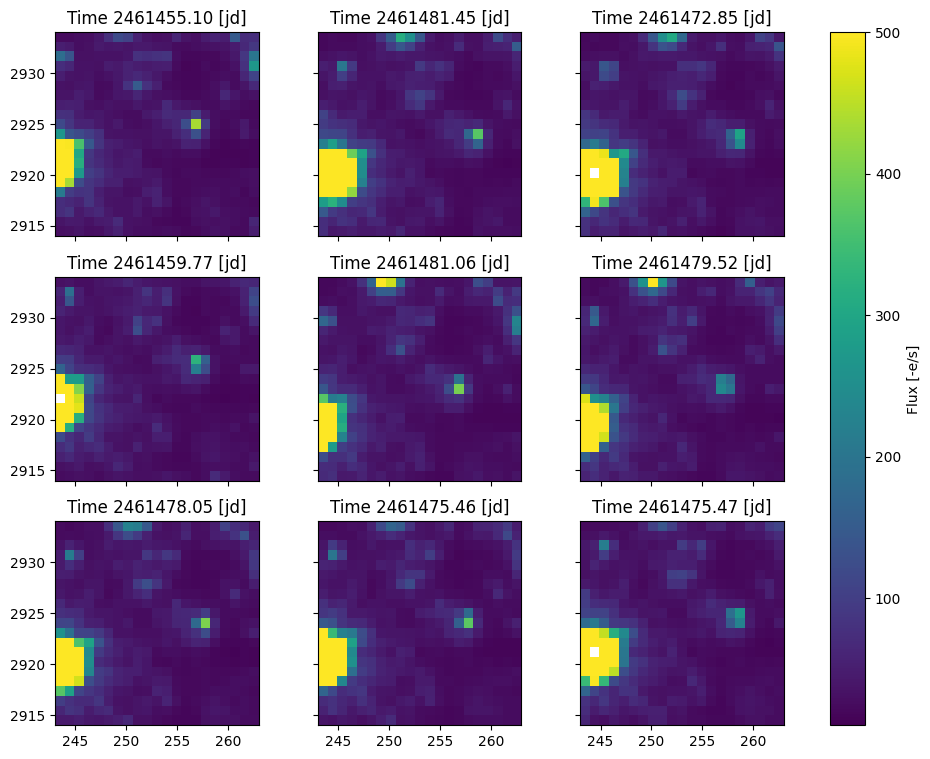

In [12]:
# we can check a few stamps

fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(12,9))
tdx = np.random.choice(np.arange(rcube.nt), size=9, replace=False)
for axis, t in zip(ax.ravel(), tdx):
    bar = axis.imshow(rcube.flux[t], 
                origin="lower", 
                vmin=10, 
                vmax=500, 
                extent=(rcube.row.min(), rcube.row.max(), rcube.column.min(), rcube.column.max()),
               )
    axis.set_title(f"Time {rcube.time[t]:.2f} [jd]")
plt.colorbar(bar, ax=ax, location="right", label="Flux [-e/s]" )
plt.show()

In [13]:
# we save the cutout to disk as ASDF file 
rcube.save_cutout(output="./test.asdf")

In [14]:
import asdf

In [18]:
af = asdf.open("./test.asdf")
af.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 4.1.0
├─history (dict)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata) ...
│   └─[1] (ExtensionMetadata) ...
└─roman (dict)
  ├─data (dict)
  │ ├─column (int): 2914
  │ ├─exposureno (NDArrayType) ...
  │ ├─flux (NDArrayType) ...
  │ ├─flux_err (NDArrayType) ...
  │ ├─quality (NDArrayType) ...
  │ ├─row (int): 243
  │ └─time (NDArrayType) ...
  ├─meta (dict)
  │ ├─CREATOR (str): TRExS-roman-cuts
  │ └─17 not shown
  └─wcs (list) ...
Some nodes not shown.


## Accounting for Dithering

In [19]:
# we can use sky coordinates to center the cutout
# the target will be centeredaccounting for dithering
radec = (268.5112137932491, -29.24473947250156)

In [20]:
# we can request all WCSs, it will take a few seconds more
rcube.make_cutout(radec=radec, size=(15, 15), dithered=True)

Using Ra, Dec coordinates and WCS per frame to center the cutout
Getting 3d data...
100%|████████████████████████████████████████████████████████████████████████████████████| 3298/3298 [00:01<00:00, 1803.93it/s]
Getting 1d arrays data...
Getting metadata


In [22]:
rcube.flux.shape

(3298, 15, 15)

In [23]:
# this time row and columns are [nt, npix]
rcube.row, rcube.column

(array([[3042, 3043, 3044, ..., 3054, 3055, 3056],
        [3042, 3043, 3044, ..., 3054, 3055, 3056],
        [3042, 3043, 3044, ..., 3054, 3055, 3056],
        ...,
        [3042, 3043, 3044, ..., 3054, 3055, 3056],
        [3042, 3043, 3044, ..., 3054, 3055, 3056],
        [3042, 3043, 3044, ..., 3054, 3055, 3056]]),
 array([[1070, 1071, 1072, ..., 1082, 1083, 1084],
        [1071, 1072, 1073, ..., 1083, 1084, 1085],
        [1071, 1072, 1073, ..., 1083, 1084, 1085],
        ...,
        [1071, 1072, 1073, ..., 1083, 1084, 1085],
        [1070, 1071, 1072, ..., 1082, 1083, 1084],
        [1073, 1074, 1075, ..., 1085, 1086, 1087]]))

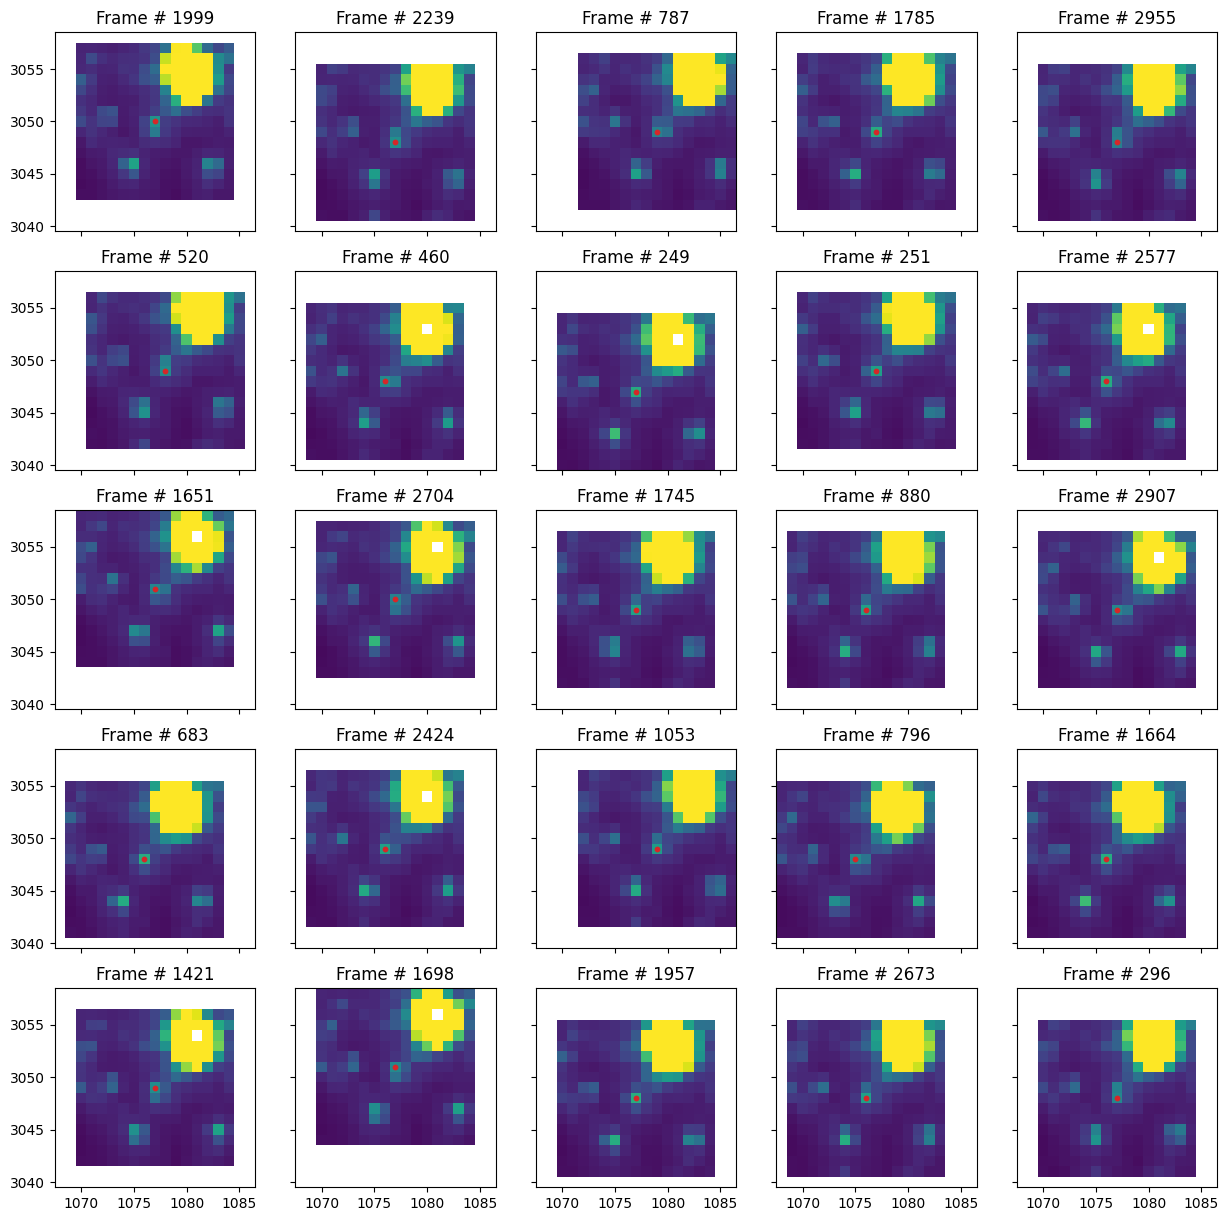

In [26]:
# visual check of the cutouts centered in the target
Ts = np.random.choice(np.arange(rcube.nt), size=5*5, replace=False)

fig, ax = plt.subplots(5,5,figsize=(15,15),sharex=True, sharey=True)
for t, axis in zip(Ts, ax.ravel()):
    axis.pcolormesh(rcube.column[t], rcube.row[t], rcube.flux[t], vmin=10, vmax=500)
    axis.scatter(rcube.target_pixel[t, 1],rcube.target_pixel[t, 0], c="tab:red", s=10)
    axis.set_title(f"Frame # {t}")
plt.show()

In [24]:
# we can save the file to disk with default name
rcube.save_cutout()

Saving data to ./roman_cutout_field03_SCA02_268.5112_-29.2447_s15x15.asdf


In [25]:
# this one contains all the WCS per frame in the ASDF
af = asdf.open("./roman_cutout_field03_SCA02_268.5112_-29.2447_s15x15.asdf")
af.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 4.1.0
├─history (dict)
│ └─extensions (list)
│   ├─[0] (ExtensionMetadata) ...
│   └─[1] (ExtensionMetadata) ...
└─roman (dict)
  ├─data (dict)
  │ ├─column (NDArrayType) ...
  │ ├─exposureno (NDArrayType) ...
  │ ├─flux (NDArrayType) ...
  │ ├─flux_err (NDArrayType) ...
  │ ├─quality (NDArrayType) ...
  │ ├─row (NDArrayType) ...
  │ └─time (NDArrayType) ...
  ├─meta (dict)
  │ ├─CREATOR (str): TRExS-roman-cuts
  │ └─17 not shown
  └─wcs (list) ...
Some nodes not shown.


In [31]:
# row and column in the ASDF have the lower-left corner pixel for each time
# we can reconstruct the pixel grid at each time with that and the cutout size.
af["roman"]["data"]["row"], af["roman"]["data"]["column"]

(array([3042, 3042, 3042, ..., 3042, 3042, 3042]),
 array([1070, 1071, 1071, ..., 1071, 1070, 1073]))